# Housing Data Analysis Project Overview

This notebook will analyze data from the King County House Sales dataset. This dataset contains various information on homes in King County. I will use this data in order to create linear regression models with the purpose of determining which features are most relevant in predicting housing prices. I will then examine the models' output and compare and contrast to determine which model performs best according to error metrics.

## Business Case/Problem

Hypothetical Situation: A King County real estate agency is looking to provide advice to home owners on what factors are most important in determining the value of their home. Using several multiple linear regression models I will examine which independant variables are most useful at predicting the dependant variable of home price. The regression models will help in providing home owners with relevant information regarding the price of their home should they be interested in listing their home with the real estate agency. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn import metrics
from sklearn.neighbors import DistanceMetric
from math import radians
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
#Function to drop unimportant columns from the dataframe.
def filter_columns(df):
    columns_to_keep = ['price','bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode',
                       'sqft_living15',
                       'sqft_lot15',
                      'lat',
                      'long']
    return df[columns_to_keep]

In [3]:
def plot_scatter(y_test, resid, title):
    plt.figure(figsize=(12,8))
    plt.scatter(y_test, resid)
    plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
    plt.title(title);

In [4]:
def errors(y_train, y_train_pred, y_test, y_test_pred):
    print('Train Mean Absolute Error:', round(metrics.mean_absolute_error(y_train, y_train_pred)))
    print('Test Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_test_pred)))
    print('Train Mean Squared Error:', round(metrics.mean_squared_error(y_train, y_train_pred)))
    print('Test Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_test_pred)))
    print('Train Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))))
    print('Test Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))))

In [5]:
def plot_model(test, test_pred, title):    
    plt.figure(figsize=(12,8))
    plt.scatter(test, test_pred)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(title);

In [6]:
#Create a function to determine the distance of the homes from a certain point (Seattle).
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

## Data Description
The data used in this project will provide the following information:

 - ID - unique identified for a house

 - Date - house was sold

 - Price - is prediction target

 - Bedrooms - number of Bedrooms/House

 - Bathrooms - number of bathrooms/bedrooms

 - Sqft_livingsquare - footage of the home

 - Sqft_lotsquare - footage of the lot

 - FloorsTotal - floors (levels) in house

 - Waterfront - House which has a view to a waterfront

 - View - Has been viewed

 - Condition - How good the condition is ( Overall )

 - Grade - overall grade given to the housing unit, based on King County grading system

 - Sqft_above - square footage of house apart from basement

 - Sqft_basement - square footage of the basement

 - Yr_built - Built Year

 - Yr_renovated - Year when house was renovated

 - Zipcode - zip

 - Lat - Latitude coordinate

 - Long - Longitude coordinate

 - Sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

 - Sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Load Data

In [7]:
#Load the Kings County housing data for analysis.
df = pd.read_csv('data/kc_house_data.csv')

In [8]:
df.shape

(21597, 21)

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [10]:
# Review remaining columns to see which ones make the most sense to keep.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.
- 'date': likely not relevant to business problem.
- 'id': likely not relevant to business problem.
- 'waterfront': large number of missing data.
- 'view': likely not relevant to business problem.
- 'yr_renovated': likely not relevant to business problem.
- 'lat': likely not relevant to business problem.
- 'long': likely not relevant to business problem.
- 'sqft_living15': already have data on sqft living.
- 'sqft_lot15': already have data on sqft lot.

## Data Cleaning

In [11]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
#Create new dataframe containing only relevant features.
df_filtered = filter_columns(df)

In [13]:
#Review new dataeframe for analysis.
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   condition      21597 non-null  int64  
 7   grade          21597 non-null  int64  
 8   sqft_above     21597 non-null  int64  
 9   yr_built       21597 non-null  int64  
 10  zipcode        21597 non-null  int64  
 11  sqft_living15  21597 non-null  int64  
 12  sqft_lot15     21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 2.5 MB


In [14]:
df_filtered.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,lat,long
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,98077.951845,1986.620318,12758.283512,47.560093,-122.213982
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,53.513072,685.230472,27274.441950,0.138552,0.140724
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,399.000000,651.000000,47.155900,-122.519000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,1490.000000,5100.000000,47.471100,-122.328000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,1840.000000,7620.000000,47.571800,-122.231000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,2360.000000,10083.000000,47.678000,-122.125000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,6210.000000,871200.000000,47.777600,-121.315000


In [15]:
#Set graph style
plt.style.use('fivethirtyeight')

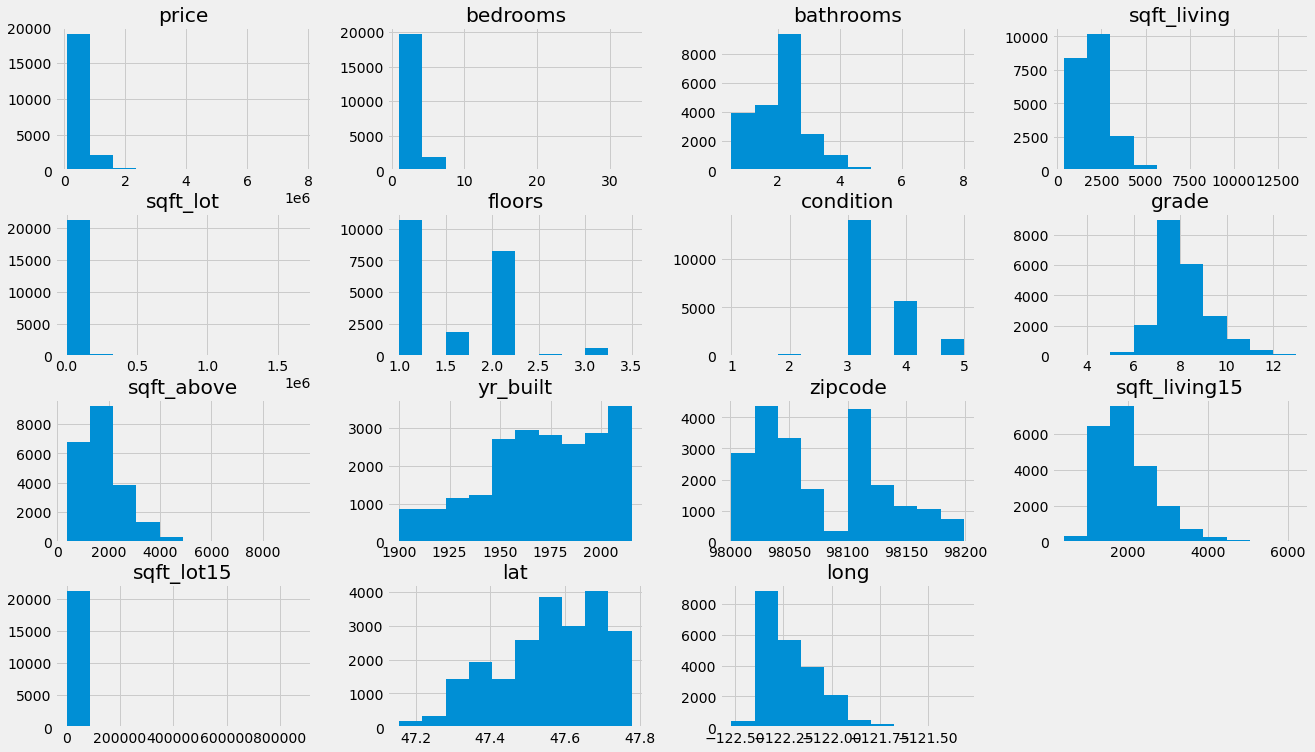

In [16]:
#Create histograms to further analyze the distribution of the features.
fig = plt.figure(figsize = (20,12))
ax = fig.gca()
df_filtered.hist(ax = ax);

<AxesSubplot:xlabel='price', ylabel='Density'>

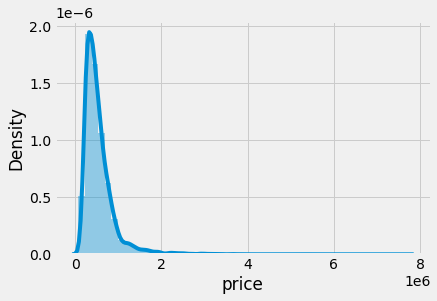

In [22]:
sns.distplot(df_filtered['price'])

<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

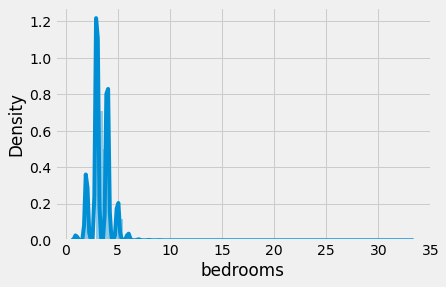

In [23]:
sns.distplot(df_filtered['bedrooms'])

In [ ]:
def boxplot(x):
    sns.boxplot(x=x, y='price', data=df_filtered);

 - 'price', 'bedrooms', 'bathrooms', sqft_living', 'sqft_lot', and 'sqft_above', 'sqft_living15', 'sqft_lot15', 'and 'yr_built' are not evenly distributed. This is likely due to outliers in the data. Outliers will need to be removed for these and some may need to be log transformed.

 - 'bedrooms', 'bathrooms', 'zipcode', 'floors', and 'condition' could be considered categorical data, which will need to be addressed later. Will likely leave 'grade' as numerical data since it appears that a higher grade equates to a higher home price.

### Check for Multicollinearity

In [ ]:
#Created heatmap to determine the multicollinearity of the features. 
sns.heatmap(df_filtered.corr(), center=0).set(title='Features Heatmap');

 - 'sqft_above' and 'sqft_living' are closely related to each other and should not be included together in any models.

# Model A (Vanilla Classifier)

Will create a basic model without transforming any features just to get an idea of how the data performs. 

## Feature Engineering

In [ ]:
#Model A features:
price_a = df_filtered['price']
bedrooms_a = df_filtered['bedrooms']
bathrooms_a = df_filtered['bathrooms']
sqft_living_a = df_filtered['sqft_living']
grade_a = df_filtered['grade']

In [ ]:
#Create dataframe for features.
simple_model_ols = pd.concat([price_a, bedrooms_a, bathrooms_a, sqft_living_a, grade_a], axis=1)
simple_model_ols.head()

### Split Data into Training and Test set

In [ ]:
#Will seperate data into training and testing sets for analysis.
target_a = simple_model_ols['price']
features_a = simple_model_ols.drop(['price'], axis=1)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(features_a,target_a,test_size=0.2,random_state=42)

## Model A Training

In [ ]:
outcome_a = 'y_train_a'
predictors_a = X_train_a
pred_sum_a = '+'.join(predictors_a.columns)
formula_a = outcome_a + '~' + pred_sum_a

In [ ]:
data_a = pd.concat([X_train_a,y_train_a], axis=1)
data_a.head()

In [ ]:
#Create OLS Model to analyze Model A.
model_a_ols = ols(formula=formula_a, data=data_a).fit()
model_a_ols.summary()

## Model A Evaluation

Model A produces p-values of 0 for each feature indicating that there likely is a relationship between the features and the target, which allows us to reject the null hypothesis for these features.  Model A, however, also produces a low R-squared value of .546, indicating that only about 54% of the model's observed variance can be explained by its inputs. Model A also produces a high Skew of 3.045, indicating that the data is not evenly distributed and will need to be transformed. Model A also has a high Kurtosis of 30.845 indicating a heavy tail and the presance of outliers.   

In [ ]:
#Create linear regression model using Sklearn.
simple_model = LinearRegression()
simple_model.fit(X_train_a,y_train_a)

In [ ]:
#Run model on training and testing data.
y_train_pred_a = simple_model.predict(X_train_a)
y_test_pred_a = simple_model.predict(X_test_a)

In [ ]:
errors(y_train_a, y_train_pred_a, y_test_a, y_test_pred_a)

 - On average Model A predicts home prices within $160,590 of the true value.

In [ ]:
#Calculate Model A residuals in order to use for graphs.
resid_a = y_test_pred_a - y_test_a

In [ ]:
#Create distribution plot to check Model A's distribution of prices.
sns.displot(x=resid_a,kind='hist',kde=True)
plt.title('Model A Price Distribution');

Model A's distribution shows a long tail in the lower price range to the left of the median price, likely indicating the prescence of outliers and confirming that the data is not evenly distributed.

In [ ]:
#Create qq plot to further analyze the distribution of the data.
fig = sm.graphics.qqplot(resid_a, dist=stats.norm, line='45',fit=True)

In [ ]:
plot_scatter(y_test_pred_a, resid_a, 'Model A Homoscedasticity')

The data appears to be bunched to the left and appears to be heteroscedastic.

In [ ]:
plot_model(y_test_a, y_test_pred_a, 'Model A Actual vs. Predicted')

The actual vs. predicted chart shows that Model A does not appear to follow a strong linear pattern. 

# Model B

## Feature Engineering

### Create Dummy Variables

In [ ]:
#Create dummy variables for zipcode data as this would make more sense as a categorical feature.
df_filtered['zipcode'] = df_filtered['zipcode'].astype('str')
df_filtered['yr_built'] = df_filtered['yr_built'].astype('int64')
df_filtered.info()

In [ ]:
#Create dummy variables and drop first column to avoid dummy variable trap.
zip_dummies = pd.get_dummies(df_filtered['zipcode'], prefix='zip', drop_first=True)

In [ ]:
#Drop original zipcode column from the dataframe.
df_dummies = df_filtered.drop(['zipcode'], axis=1)

In [ ]:
#Create new dataframe with the dummy variable columns.
df_dummies = pd.concat([df_filtered, zip_dummies], axis=1)
df_dummies.head()

In [ ]:
df_dummies.describe()

## Model B Training

In [ ]:
#Create Model B features, which will be scaled in order to be able to compare between eachother more easily.
price_b = df_dummies['price']
bedrooms_b = df_dummies['bedrooms']
scaled_bed_b = (bedrooms_b-np.mean(bedrooms_b))/np.sqrt(np.var(bedrooms_b))
bathrooms_b = df_dummies['bathrooms']
scaled_bath_b = (bathrooms_b-np.mean(bathrooms_b))/np.sqrt(np.var(bathrooms_b))
#Log transform 'sqft_living' in order to make it more evenly distributed.
logsqft = np.log(df_filtered['sqft_living'])
scaled_sqft = (logsqft-np.mean(logsqft))/np.sqrt(np.var(logsqft))
zip_dummies
yr_b = df_dummies['yr_built']
scaled_yr_b = (yr_b-np.mean(yr_b))/np.sqrt(np.var(yr_b))

In [ ]:
model_b = pd.concat([price_b, scaled_bed_b, scaled_bath_b, scaled_sqft, zip_dummies, scaled_yr_b], axis=1)
model_b.head()

### Split Data into Training and Test Set

In [ ]:
#Split data into training and testing sets for analysis.
target_b = model_b['price']
features_b = model_b.drop(['price'], axis=1)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features_b,target_b,test_size=0.2,random_state=42)
X_train_b.head()

In [ ]:
outcome_b = 'y_train_b'
predictors_b = X_train_b
pred_sum_b = '+'.join(predictors_b.columns)
formula_b = outcome_b + '~' + pred_sum_b

In [ ]:
data_b = pd.concat([X_train_b,y_train_b], axis=1)
data_b.head()

In [ ]:
#Create Model B OLS model. 
model_b_ols = ols(formula=formula_b, data=data_b).fit()
model_b_ols.summary()

## Model B Evaluation

While Model B produces a better R-squared value of .668 than Model A there are also high p-values for some of zip code dummy variables, meaning that these high p-values are insignificant for the model and will need to be removed. Model B also produces a higher Skew than Model A at 4.983, indicating that the data is less evenly distributed and will need to be transformed. Model B also has a much higher Kurtosis of 69.100 indicating more outliers than Model A, this is likely due to the high p-value dummy variables that will need to removed.

In [ ]:
#Create linear regression model using Sklearn.
model_b_lr = LinearRegression()
model_b_lr.fit(X_train_b,y_train_b)

In [ ]:
#Run model on training and testing data.
y_train_pred_b = model_b_lr.predict(X_train_b)
y_test_pred_b = model_b_lr.predict(X_test_b)

In [ ]:
errors(y_train_b, y_train_pred_b, y_test_b, y_test_pred_b)

On average Model B predicts home prices within $122,502 of the true home value.

In [ ]:
#Calculate Model B residuals in order to use for graphs.
resid_b = y_test_pred_b - y_test_b

In [ ]:
#Create distribution plot to check Model B's distribution of prices.
sns.displot(x=resid_b,kind='hist',kde=True)
plt.title('Model B Price Distribution');

In [ ]:
#Create qq plot to further analyze the distribution of the data.
fig = sm.graphics.qqplot(resid_b, dist=stats.norm, line='45',fit=True)

In [ ]:
plot_scatter(y_test_pred_b, resid_b, 'Model B Homoscedasticity')

In [ ]:
plot_model(y_test_b, y_test_pred_b, 'Model B Actual vs. Predicted')

# Model C

## Remove Outliers

 - Will remove outliers for certain features in order to make the data more normally distributed and address high skewness and kurtosis from Model's A and B.

In [ ]:
df_filtered.bathrooms.mean()

In [ ]:
df_filtered.bathrooms.std()

In [ ]:
df_filtered.bedrooms.mean()

In [ ]:
df_filtered.bedrooms.std()

In [ ]:
#Find the upper limit of three standard deviations for 'bathrooms'. 
upper_limit = df_filtered.bathrooms.mean() + 3*df_filtered.bathrooms.std()
upper_limit

In [ ]:
#Find the upper limit of three standard deviations for 'bedrooms'.
upper_limit_beds = df_filtered.bedrooms.mean() + 3*df_filtered.bedrooms.std()
upper_limit_beds

In [ ]:
#Find the lower limit of three deviations for 'bathrooms'.
lower_limit = df_filtered.bathrooms.mean() - 3*df_filtered.bathrooms.std()
lower_limit

In [ ]:
#Find the lower limit of three standard deviations for 'bedrooms'.
lower_limit_beds = df_filtered.bedrooms.mean() - 3*df_filtered.bedrooms.std()
lower_limit_beds

In [ ]:
#Find the upper limit of three standard deviations for 'price'.
upper_limit_price = df_filtered.price.mean() + 3*df_filtered.price.std()
upper_limit_price

In [ ]:
#Find the lower limit of three standard deviations for 'price'.
lower_limit_price = df_filtered.price.mean() - 3*df_filtered.price.std()
lower_limit_price

In [ ]:
#Create new dataframe removing the upper and lower limit outliers for 'bathrooms', 'bedrooms', and 'price'.
df_outliers=df_filtered[(df_filtered.bathrooms<upper_limit) & (df_filtered.bathrooms>lower_limit) 
                        & (df_filtered.bedrooms<upper_limit_beds) & (df_filtered.bedrooms>lower_limit_beds)
                       & (df_filtered.price<upper_limit_price) & (df_filtered.price>lower_limit_price)]
df_outliers.info()

In [ ]:
#Check new distributions of the features.
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_outliers.hist(ax = ax);

In [ ]:
zip_dummies_c = pd.get_dummies(df_outliers['zipcode'], prefix='zip', drop_first=True)

In [ ]:
#Update zip dummies to remove the zip codes with high p-values.
updated_zip_c = zip_dummies_c.drop(['zip_98002','zip_98003','zip_98022','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042','zip_98055','zip_98058','zip_98092',
                                  'zip_98188','zip_98168','zip_98178','zip_98188','zip_98148','zip_98198'], axis=1)
updated_zip_c.head()

In [ ]:
#Create Model C features, which will be scaled in order to be able to compare between eachother more easily.
model_c = pd.DataFrame([])
price_c = df_outliers['price']
bathrooms_c = df_outliers['bathrooms']
scaled_bath_c = (bathrooms_c-np.mean(bathrooms_c))/np.sqrt(np.var(bathrooms_c))
bedrooms_c = df_outliers['bedrooms']
scaled_bed_c = (bedrooms_c-np.mean(bedrooms_c))/np.sqrt(np.var(bedrooms_c))
#Will log transform 'sqft_lot' in order to get a more even distribution.
log_lot_c = np.log(df_outliers['sqft_lot'])
scaled_log_lot_c = (log_lot_c-np.mean(log_lot_c))/np.sqrt(np.var(log_lot_c))
updated_zip_c
sqfta_c = df_outliers['sqft_above']
scaled_sqfta_c = (sqfta_c-np.mean(sqfta_c))/np.sqrt(np.var(sqfta_c))

In [ ]:
sns.displot(x=scaled_log_lot_c,kind='hist',kde=True);

## Model C Training

In [ ]:
model_c = pd.concat([price_c, scaled_bath_c, scaled_log_lot_c, scaled_sqfta_c, updated_zip_c], axis=1)
model_c.head()

In [ ]:
model_c.describe()

In [ ]:
#Seperate Model C into training and testing datasets for analysis.
target_c = model_c['price']
features_c = model_c.drop(['price'], axis=1)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_c,target_c,test_size=0.2,random_state=42)
X_train_c.head()

In [ ]:
outcome_c = 'y_train_c'
predictors_c = X_train_c
pred_sum_c = '+'.join(predictors_c.columns)
formula_c = outcome_c + '~' + pred_sum_c

In [ ]:
data_c = pd.concat([X_train_c,y_train_c], axis=1)
data_c.head()

In [ ]:
#Creat Model C OLS model.
model_c_ols = ols(formula=formula_c, data=data_c).fit()
model_c_ols.summary()

## Model C Evaluation

Model C produces a higher R-squared than both models A and B. Also the skew and kurtosis have both significantly decreased indicating more evenly distributed data. There is also one zip code with a high p-value likely due to the presence of an outlier. It also appears that sqft_above contributes more to the home price than does sqft_lot and bathrooms according to the coefficiants. Also looking at the coefficiants we can see that certain zip codes are the most important factor in determing the price of the home.  

In [ ]:
model_c_lr = LinearRegression()
model_c_lr.fit(X_train_c,y_train_c)

In [ ]:
y_train_pred_c = model_c_lr.predict(X_train_c)
y_test_pred_c = model_c_lr.predict(X_test_c)

In [ ]:
errors(y_train_c, y_train_pred_c, y_test_c, y_test_pred_c)

In [ ]:
resid_c = y_test_pred_c - y_test_c
resid_c

In [ ]:
sns.displot(x=resid_c,kind='hist',kde=True)
plt.title('Price Distribution');

In [ ]:
fig = sm.graphics.qqplot(resid_c, dist=stats.norm, line='45',fit=True)

In [ ]:
plot_scatter(y_test_pred_c, resid_c, 'Model C Homoscedasticity')

In [ ]:
plot_model(y_test_c, y_test_pred_c, 'Model C Actual vs. Predicted')

# Model D

### Remove Outliers

In [ ]:
df_filtered.sqft_living.std()

In [ ]:
upper_limit_sqft = df_filtered.sqft_living.mean() + 3*df_filtered.sqft_living.std()
upper_limit_sqft

In [ ]:
lower_limit_sqft = df_filtered.sqft_living.mean() - 3*df_filtered.sqft_living.std()
lower_limit_sqft

In [ ]:
df_filtered.sqft_lot.std()

In [ ]:
upper_limit_lot = df_filtered.sqft_lot.mean() + 1*df_filtered.sqft_lot.std()
upper_limit_lot

In [ ]:
lower_limit_lot = df_filtered.sqft_lot.mean() - 3*df_filtered.sqft_lot.std()
lower_limit_lot

In [ ]:
upper_limit_sqft15 = df_filtered.sqft_living15.mean() + 3*df_filtered.sqft_living15.std()
upper_limit_sqft15

In [ ]:
lower_limit_sqft15 = df_filtered.sqft_living15.mean() - 3*df_filtered.sqft_living15.std()
lower_limit_sqft15

In [ ]:
df_outliers_2=df_outliers[(df_filtered.sqft_living<upper_limit_sqft) & (df_filtered.sqft_living>lower_limit_sqft) 
                         & (df_filtered.sqft_lot<upper_limit_lot) & (df_filtered.sqft_lot>lower_limit_lot)
                        & (df_filtered.sqft_living15<upper_limit_sqft15) & (df_filtered.sqft_living15>lower_limit_sqft15)]
df_outliers_2.info()

## Feature Engineering

Will create a new feature consisting of the sum of sqft living and the average sqft living of the nearest 15 neighbors. This should give a better idea of the price due to the grouping of homes in neighborhoods with larger homes also in the area.

In [ ]:
sum_sqft_liv = df_outliers_2['sqft_living'] + df_outliers_2['sqft_living15']
df_outliers_2['sum_sqft_liv'] = sum_sqft_liv
df_outliers_2.head()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_outliers_2.hist(ax = ax);

 - Will create a new feature conisisting of the distance from the homes to Seattle. I would expect home values to increase as they become closer to the city.

In [ ]:
#Seattle Longitude/Latitude
start_lat, start_long = 47.6062, 122.3321

In [ ]:
lat_a = df_outliers_2['lat']
long_a = df_outliers_2['long']

In [ ]:
homes_lat_long = pd.concat([lat_a, long_a], axis=1)
homes_lat_long.head()

In [ ]:
distances_km = []
for row in homes_lat_long.itertuples(index=False):
   distances_km.append(
       haversine_distance(start_lat, start_long, row.lat, row.long)
   )

In [ ]:
homes_lat_long['Distance_From_Seattle'] = distances_km

In [ ]:
homes_lat_long.info()

In [ ]:
price_d = df_outliers_2['price']
grade_d = df_outliers_2['grade']
scaled_grade_d = (grade_d-np.mean(grade_d))/np.sqrt(np.var(grade_d))
bathrooms_d = df_outliers_2['bathrooms']
scaled_bath_d = (bathrooms_d-np.mean(bathrooms_d))/np.sqrt(np.var(bathrooms_d))
bedrooms_d = df_outliers_2['bedrooms']
scaled_bed_d = (bedrooms_d-np.mean(bedrooms_d))/np.sqrt(np.var(bedrooms_d))
sqft_living_d = df_outliers_2['sqft_living']
scaled_sqftl_d = (sqft_living_d-np.mean(sqft_living_d))/np.sqrt(np.var(sqft_living_d))
zip_dummies_d = pd.get_dummies(df_outliers_2['zipcode'], prefix='zip', drop_first=True)
updated_zip_d = zip_dummies_d.drop(['zip_98002','zip_98003','zip_98022','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042','zip_98055','zip_98058','zip_98092',
                                  'zip_98188','zip_98168','zip_98178','zip_98188','zip_98148','zip_98198'], axis=1)
log_yr_d = np.log(df_outliers_2['yr_built'])
scaled_yr_d = (log_yr_d-np.mean(log_yr_d))/np.sqrt(np.var(log_yr_d))

In [ ]:
sum_sqft_liv_d = df_outliers_2['sum_sqft_liv']
scaled_sqft_liv = (sum_sqft_liv_d-np.mean(sum_sqft_liv_d))/np.sqrt(np.var(sum_sqft_liv_d))

In [ ]:
distance = homes_lat_long['Distance_From_Seattle']
scaled_distance = (distance-np.mean(distance))/np.sqrt(np.var(distance))

## Model D Training

In [ ]:
model_d = pd.concat([price_d, scaled_bath_d, scaled_distance, scaled_grade_d, scaled_sqft_liv, updated_zip_d, scaled_yr_d], axis=1)
model_d.head()

In [ ]:
target_d = model_d['price']
features_d = model_d.drop(['price'], axis=1)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(features_d,target_d,test_size=0.2,random_state=42)

In [ ]:
outcome_d = 'y_train_d'
predictors_d = X_train_d
pred_sum_d = '+'.join(predictors_d.columns)
formula_d = outcome_d + '~' + pred_sum_d

In [ ]:
data_d = pd.concat([X_train_d,y_train_d], axis=1)
data_d.head()

In [ ]:
model_d_ols = ols(formula=formula_d, data=data_d).fit()
model_d_ols.summary()

## Model D Evalutation

Model D produces a slighly higher R-squared than Model C at .805. Model D also has significantly lower skew and kurtosis than both Model's A and B while being fairly similar to Model C. All of the p-values in Model D are 0 indicating that all of the features statistically significant. Also looking at the coefficiants it appears that grade and year built contribute more to the home price than bathrooms and distance from Seattle. Finally square foot living as well as certain zip codes appear to be the most significant factors in contributing to the home price according to the coefficiants, this is similar to what was observed in both Model's B and C.

In [ ]:
model_d_lr = LinearRegression()
model_d_lr.fit(X_train_d, y_train_d)

In [ ]:
y_train_pred_d = model_d_lr.predict(X_train_d)
y_test_pred_d = model_d_lr.predict(X_test_d)

In [ ]:
errors(y_train_d, y_train_pred_d, y_test_d, y_test_pred_d)

In [ ]:
resid_d = y_test_pred_d - y_test_d
resid_d

In [ ]:
sns.displot(x=resid_d,kind='hist',kde=True)
plt.title('Price Distribution');

In [ ]:
fig = sm.graphics.qqplot(resid_d, dist=stats.norm, line='45',fit=True)

In [ ]:
plot_scatter(y_test_pred_d, resid_d, 'Model D Homoscedasticity')

In [ ]:
plot_model(y_test_d, y_test_pred_d, 'Model D Actual vs. Predicted')

## Model Comparison

In [ ]:
data = {'R-Squared':[.546, .668, .756, .804],
       'Skew':[3.045, 4.983, 1.292, 1.292],
       'Kurtosis':[30.845, 69.1, 8.668, 9.157],
       'MAE (test)':['160,590', '122,502', '91,518', '77,473'],
       'MSE (test)':['60,591,750,008', '46,626,531,192', '18,263,182,375', '12,325,876,561'],
       'RMSE (test)':['246,153', '215,931', '135,141', '111,021']}
model_comparison = pd.DataFrame(data, index=['Model A', 'Model B', 'Model C', 'Model D'])
model_comparison

## Model Selection

Based on the model comparison above, Model D seems to most accurate of the group with the highest R-Squared, as well as lowest MAE, MSE, and RMSE. 

In [ ]:
#Will run Model D with all the of the data without splitting.
final_model = pd.concat([price_d, scaled_bath_d, scaled_distance, scaled_grade_d, 
                     scaled_sqft_liv, updated_zip_d, scaled_yr_d], axis=1)

In [ ]:
target_e = final_model['price']
features_e = final_model.drop(['price'], axis=1)

In [ ]:
outcome_e = 'price'
predictors_e = final_model.drop(['price'], axis=1)
pred_sum_e = '+'.join(predictors_e.columns)
formula_e = outcome_e + '~' + pred_sum_e

In [ ]:
final_model_ols = ols(formula=formula_e, data=final_model).fit()
final_model_ols.summary()

In [ ]:
final_model_e = LinearRegression()
final_model_e.fit(features_e, target_e)

In [ ]:
y_pred_e = final_model_e.predict(features_e)

In [ ]:
print('Train Mean Absolute Error:',metrics.mean_absolute_error(target_e, y_pred_e))

In [ ]:
print('Train Mean Squared Error:',metrics.mean_squared_error(target_e, y_pred_e))

In [ ]:
print('Train Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(target_e, y_pred_e)))

Running the model with all of the data produces a result very similar to the Model D results. This indicates that this model does not appear to be overfitting the data.

## Conclusions/Summary

Overall it appears that both Zip Codes and Square foot living, Square foot above, and Sum square foot living tend to be the most important factors in determining the actual price of homes. In models B, C, and D these two features produce the highest coeffiecients indicating that they have the stongest relationship with the dependent variable of price. This finding remains true as the models become more accurate and the data becomes more normally distributed accross different models. One interestering finding is that in model A we observed that Square foot living appeared to be the lowest coeffiecient, however this is likely due to the fact that the features were not scaled in this particular model, whereas in models B, C, and D all features were scaled before running the models.  

## Model D Graphs of Features vs. Price

In [ ]:
x = df_outliers_2['sum_sqft_liv']
y = df_outliers_2['price']
plt.figure(figsize=(12,8))
plt.xlabel('Sum Sqft Living')
plt.ylabel('Home Price')
plt.title('Sum Sqft Living vs. Price')
sns.regplot(x, y);

In [ ]:
x = homes_lat_long['Distance_From_Seattle']
y = df_outliers_2['price']
plt.figure(figsize=(12,8))
plt.xlabel('Distance')
plt.ylabel('Home Price')
plt.title('Distance From Seattle vs. Price')
sns.regplot(x, y);

In [ ]:
grouped_grade = df_outliers_2.groupby('grade').mean()
grouped_grade.reset_index(inplace=True)
grouped_grade

In [ ]:
grouped_baths = df_outliers_2.groupby('bathrooms').mean()
grouped_baths.reset_index(inplace=True)
grouped_baths.head()

In [ ]:
x = grouped_grade['grade']
y = grouped_grade['price']
plt.figure(figsize=(12,8))
plt.xlabel('Grade')
plt.ylabel('Home Price')
plt.title('Grade vs. Price')
sns.regplot(x, y);

In [ ]:
x = grouped_baths['bathrooms']
y = grouped_baths['price']
plt.figure(figsize=(12,8))
plt.xlabel('Bathrooms')
plt.ylabel('Home Price')
plt.title('Bathrooms vs. Price')
sns.regplot(x, y);